In [1]:
# Steven Jordan
# DSC 478 - Final Project
# Board Game Recommendation Engine

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing as skp

In [3]:
# Reads the csv file, showing that there are 4999 entries, with 20 columns
df = pd.read_csv('bgg.csv')
print(df.shape)
print(df.head(3))

(4999, 20)
   rank                                            bgg_url  game_id  \
0     1  https://boardgamegeek.com/boardgame/174430/glo...   174430   
1     2  https://boardgamegeek.com/boardgame/161936/pan...   161936   
2     3  https://boardgamegeek.com/boardgame/182028/thr...   182028   

                                           names  min_players  max_players  \
0                                     Gloomhaven            1            4   
1                      Pandemic Legacy: Season 1            2            4   
2  Through the Ages: A New Story of Civilization            2            4   

   avg_time  min_time  max_time  year  avg_rating  geek_rating  num_votes  \
0       120        60       120  2017     8.98893      8.61858      15376   
1        60        60        60  2015     8.66140      8.50163      26063   
2       240       180       240  2015     8.60673      8.30183      12352   

                                           image_url  age  \
0  https://cf.geekdo-

In [4]:
# Initial Exploration, Data Cleaning, and Pre-processing

# Remove unnecessary columns
data_and_labels = df.drop(['rank', 'game_id', 'min_time', 'max_time', 'year', 'avg_rating', 'num_votes', 'image_url', 'owned', 'designer'], axis = 1)
print(data_and_labels.shape)

# Initial descriptions show there are non-unique names, and many games with missing values
#print(data_and_labels.describe(include = 'all'))

(4999, 10)


In [5]:
# Remove games with missing numeric values (423 games)
# Most of these entries are simply missing from the website because they either weren't provided
# by the publisher, or they just don't appear to be encoded

data_and_labels = data_and_labels[data_and_labels.weight != 0]
data_and_labels = data_and_labels[data_and_labels.min_players != 0]
data_and_labels = data_and_labels[data_and_labels.max_players != 0]
data_and_labels = data_and_labels[data_and_labels.avg_time != 0]
data_and_labels = data_and_labels[data_and_labels.age != 0]
data_and_labels = data_and_labels[data_and_labels.category != 'none']
data_and_labels = data_and_labels[data_and_labels.mechanic != 'none']

data_and_labels.shape

(4576, 10)

In [6]:
# Duplicate names appear to be different (though often related) games
#print(data_and_labels['names'].value_counts())

1     759
2    3119
3     580
4      95
5      13
6       6
8       4
Name: min_players, dtype: int64
IQR:  0.0
1.5*IQR Range:  (2.0, 2.0)


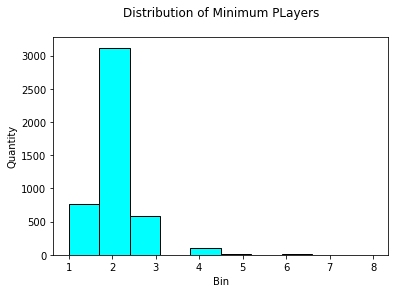

In [7]:
# Explore non-categorical variables, detect and manage outliers
# Minimum number of players distribtion
plt.hist(data_and_labels['min_players'],  color = 'cyan', ec = 'black')
print(data_and_labels['min_players'].value_counts().sort_index())
plt.title('Distribution of Minimum PLayers\n')
plt.ylabel('Quantity')
plt.xlabel('Bin')

#IQR doesn't work for outlier detection, using domain knowledge
min_iqr = data_and_labels['min_players'].quantile(0.75) - data_and_labels['min_players'].quantile(0.25)
min_iqr_range = (data_and_labels['min_players'].quantile(0.25) - 1.5*min_iqr, data_and_labels['min_players'].quantile(0.75) + 1.5*min_iqr)
print("IQR: ", min_iqr)
print("1.5*IQR Range: ", min_iqr_range)


Text(0.5, 0, 'Bin')

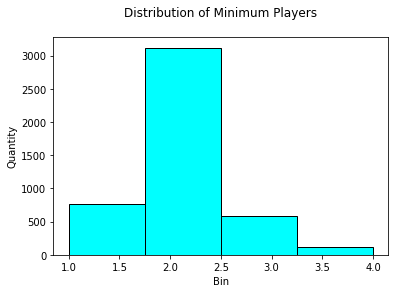

In [8]:
# Domain knowledge, replacing all min_player above 4 values to 4. Accounts for 0.5% of games.
data_and_labels.loc[data_and_labels.min_players > 4, 'min_players'] = 4
plt.hist(data_and_labels['min_players'], bins = 4,  color = 'cyan', ec = 'black')
plt.title('Distribution of Minimum Players\n')
plt.ylabel('Quantity')
plt.xlabel('Bin')

1        68
2       801
3        57
4      1569
5       861
6       738
7        87
8       200
9        16
10       69
11        2
12       41
13        1
15        4
16        8
18        8
20       10
21        2
24        3
30        4
33        1
34        1
52        1
68        1
75        1
99       20
100       2
Name: max_players, dtype: int64
IQR:  2.0
1.5*IQR Range:  (1.0, 9.0)


Text(0.5, 0, 'Bin')

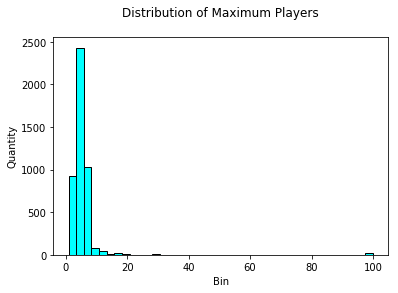

In [9]:
# Maximum number of players distribution
print(data_and_labels['max_players'].value_counts().sort_index())

#IQR makes sense, agrees with domain knowledge
max_iqr = data_and_labels['max_players'].quantile(0.75) - data_and_labels['max_players'].quantile(0.25)
max_iqr_range = (data_and_labels['max_players'].quantile(0.25) - 1.5*max_iqr, data_and_labels['max_players'].quantile(0.75) + 1.5*max_iqr)
print("IQR: ", max_iqr)
print("1.5*IQR Range: ", max_iqr_range)

plt.hist(data_and_labels['max_players'], bins = 40, color = 'cyan', ec = 'black')
plt.title('Distribution of Maximum Players\n')
plt.ylabel('Quantity')
plt.xlabel('Bin')


1      68
2     801
3      57
4    1569
5     861
6     738
7      87
8     200
9     195
Name: max_players, dtype: int64


Text(0.5, 0, 'Bin')

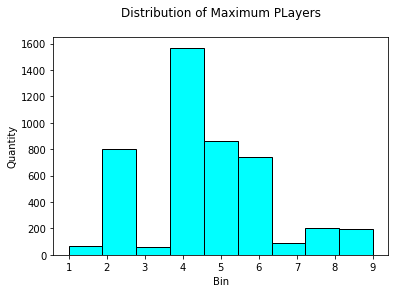

In [10]:
# Domain knowledge, replacing all max_player above 9 values to 9. Accounts for 3.9% of games.
data_and_labels.loc[data_and_labels.max_players > 9, 'max_players'] = 9
print(data_and_labels['max_players'].value_counts().sort_index())
plt.hist(data_and_labels['max_players'], bins = 9, color = 'cyan', ec = 'black')
plt.title('Distribution of Maximum PLayers\n')
plt.ylabel('Quantity')
plt.xlabel('Bin')

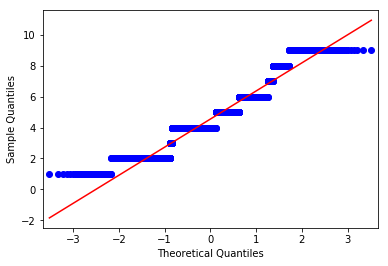

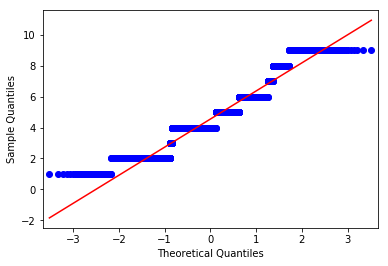

In [11]:
# Appears to be normally distributed
from statsmodels.graphics.gofplots import qqplot
qqplot(data_and_labels['max_players'], line='s')

1          1
2          2
5         10
10        80
12         1
13         2
15       171
19         1
20       285
25        50
30       714
32         2
35        15
40        98
42         1
45       573
50        27
55         2
60       771
70        12
75        70
80        12
90       509
95         1
100       24
105        1
110        1
115        1
120      461
125        2
        ... 
250        1
290        1
300       46
360       95
420        4
480       17
540        1
600        6
660        1
720        6
840        1
900        2
960        3
999        1
1000       4
1200       6
1440       1
1500       2
1800       1
2400       2
2480       1
2880       2
3000       3
3600       3
4320       1
4500       2
5400       1
6000       2
12000      1
22500      1
Name: avg_time, Length: 68, dtype: int64
IQR:  70.0
1.5*IQR Range:  (-75.0, 205.0)


Text(0.5, 0, 'Bin')

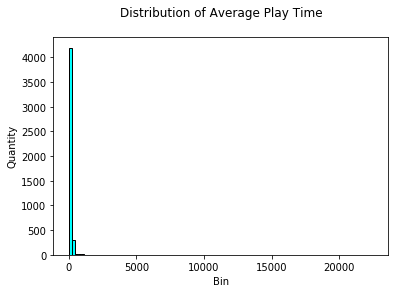

In [12]:
# Average game length distribution. Some games with crazy long or short average playtimes
print(data_and_labels['avg_time'].value_counts().sort_index())

# IQR
time_iqr = data_and_labels['avg_time'].quantile(0.75) - data_and_labels['avg_time'].quantile(0.25)
time_iqr_range = (data_and_labels['avg_time'].quantile(0.25) - 1.5*time_iqr, data_and_labels['avg_time'].quantile(0.75) + 1.5*time_iqr)
print("IQR: ", time_iqr)
print("1.5*IQR Range: ", time_iqr_range)

# Very skewed due to long play times
plt.hist(data_and_labels['avg_time'],bins = 100, color = 'cyan', ec = 'black')
plt.title('Distribution of Average Play Time\n')
plt.ylabel('Quantity')
plt.xlabel('Bin')


Text(0.5, 0, 'Bin')

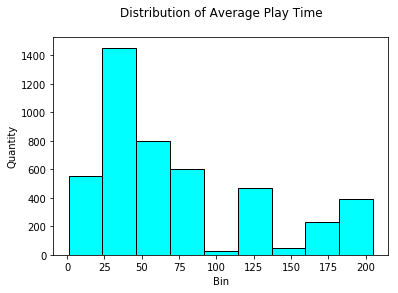

In [13]:
# Replacing games' average time over 205 mins with 205 mins, accounts for 8.45% of games
data_and_labels.loc[data_and_labels.avg_time > 205, 'avg_time'] = 205
plt.hist(data_and_labels['avg_time'], bins = 9, color = 'cyan', ec = 'black')
plt.title('Distribution of Average Play Time\n')
plt.ylabel('Quantity')
plt.xlabel('Bin')


2        1
3        6
4       17
5       32
6       83
7       80
8      769
9       78
10    1050
11      29
12    1360
13     447
14     524
15      40
16      27
17      11
18      19
21       2
42       1
Name: age, dtype: int64
IQR:  2.0
IQR Range:  (7.0, 15.0)


Text(0.5, 0, 'Bin')

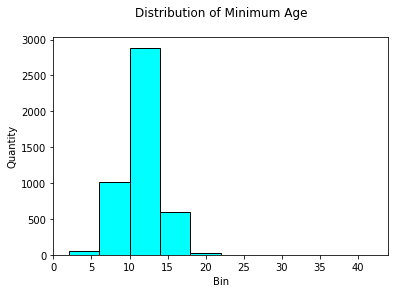

In [14]:
# Minimum Age attribute
print(data_and_labels['age'].value_counts().sort_index())

# IQR is too restrictive - choosing not to implement it because it misses out on important types of games
age_iqr = data_and_labels['age'].quantile(0.75) - data_and_labels['age'].quantile(0.25)
age_iqr_range = (data_and_labels['age'].quantile(0.25) - 1.5*age_iqr, data_and_labels['age'].quantile(0.75) + 1.5*age_iqr)
print("IQR: ", age_iqr)
print("IQR Range: ", age_iqr_range)

# Appears to have a normal distribution with one outlier
plt.hist(data_and_labels['age'], color = 'cyan', ec = 'black')
plt.title('Distribution of Minimum Age\n')
plt.ylabel('Quantity')
plt.xlabel('Bin')

Text(0.5, 0, 'Bin')

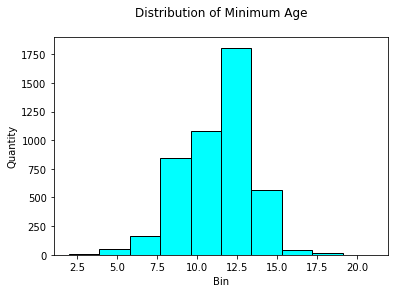

In [15]:
# Remove the game with minimum age of 42 (it is null on the website)
data_and_labels = data_and_labels[data_and_labels.age != 42]
plt.hist(data_and_labels['age'], color = 'cyan', ec = 'black')
plt.title('Distribution of Minimum Age\n')
plt.ylabel('Quantity')
plt.xlabel('Bin')

IQR:  1.1378
1.5*IQR Range:  (0.043300000000000116, 4.5945)
Min: 1.0
Max: 4.9048


Text(0.5, 0, 'Bin')

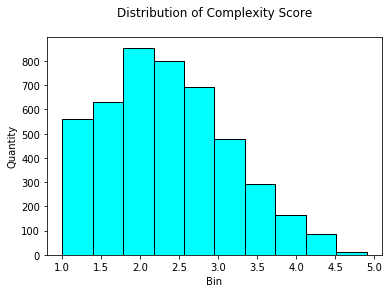

In [16]:
# Complexity distribution (weight) determined by BGG user ratings
plt.hist(data_and_labels['weight'], color = 'cyan', ec = 'black')
weight_iqr = data_and_labels['weight'].quantile(0.75) - data_and_labels['weight'].quantile(0.25)
weight_iqr_range = (data_and_labels['weight'].quantile(0.25) - 1.5*weight_iqr, data_and_labels['weight'].quantile(0.75) + 1.5*weight_iqr)
print("IQR: ", weight_iqr)
print("1.5*IQR Range: ", weight_iqr_range)

print('Min:', min(data_and_labels['weight']))
print('Max:',max(data_and_labels['weight']))

plt.hist(data_and_labels['weight'], color = 'cyan', ec = 'black')
plt.title('Distribution of Complexity Score\n')
plt.ylabel('Quantity')
plt.xlabel('Bin')

Text(0.5, 0, 'Bin')

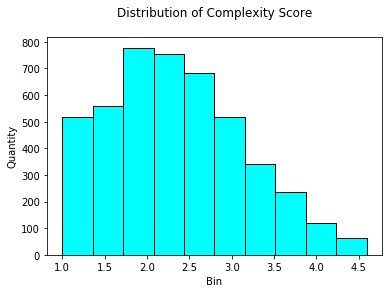

In [17]:
# Adjust the higher end of the weight outliers to max IQR
data_and_labels.loc[data_and_labels.weight > 4.5945, 'weight'] = 4.5945
plt.hist(data_and_labels['weight'], color = 'cyan', ec = 'black')
plt.title('Distribution of Complexity Score\n')
plt.ylabel('Quantity')
plt.xlabel('Bin')

In [18]:
# Create dummy variables for the mechanics (51 total different mechanics)
pd.options.display.max_columns = 100
mechanics_dummies = data_and_labels.mechanic.str.get_dummies(sep =', ')
mechanics_dummies.head(3)


,Acting,Action / Movement Programming,Action Point Allowance System,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,Card Drafting,Chit-Pull System,Co-operative Play,Commodity Speculation,Crayon Rail System,Deck / Pool Building,Dice Rolling,Grid Movement,Hand Management,Hex-and-Counter,Line Drawing,Memory,Modular Board,Paper-and-Pencil,Partnerships,Pattern Building,Pattern Recognition,Pick-up and Deliver,Player Elimination,Point to Point Movement,Press Your Luck,Rock-Paper-Scissors,Role Playing,Roll / Spin and Move,Route/Network Building,Secret Unit Deployment,Set Collection,Simulation,Simultaneous Action Selection,Singing,Stock Holding,Storytelling,Take That,Tile Placement,Time Track,Trading,Trick-taking,Variable Phase Order,Variable Player Powers,Voting,Worker Placement
0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# The minimum # of mechanics is 1, the max is 18, and the mean is 3.02
mechs = []
for line in np.array(mechanics_dummies):
    mechs.append(sum(line))
    
print("Max: ", max(mechs))
print("Min: ", min(mechs))
print("Mean: ", np.mean(mechs))

Max:  18
Min:  1
Mean:  3.021857923497268


In [20]:
# Create dummy variables for the mechanics (83 total different mechanics)
category_dummies = data_and_labels.category.str.get_dummies(sep =', ')
category_dummies.head(3)


,Abstract Strategy,Action / Dexterity,Adventure,Age of Reason,American Civil War,American Indian Wars,American Revolutionary War,American West,Ancient,Animals,Arabian,Aviation / Flight,Bluffing,Book,Card Game,Children's Game,City Building,Civil War,Civilization,Collectible Components,Comic Book / Strip,Deduction,Dice,Economic,Educational,Electronic,Environmental,Expansion for Base-game,Exploration,Fantasy,Farming,Fighting,Game System,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,Mature / Adult,Maze,Medical,Medieval,Memory,Miniatures,Modern Warfare,Movies / TV / Radio theme,Murder/Mystery,Music,Mythology,Napoleonic,Nautical,Negotiation,Novel-based,Number,Party Game,Pike and Shot,Pirates,Political,Post-Napoleonic,Prehistoric,Print & Play,Puzzle,Racing,Real-time,Religious,Renaissance,Science Fiction,Space Exploration,Spies/Secret Agents,Sports,Territory Building,Trains,Transportation,Travel,Trivia,Video Game Theme,Vietnam War,Wargame,Word Game,World War I,World War II,Zombies
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# The minimum # of categories is 1, the max is 12, and the mean is 2.78
cats = []
for line in np.array(category_dummies):
    cats.append(sum(line))
    
print("Max: ", max(cats))
print("Min: ", min(cats))
print("Mean: ", np.mean(cats))

Max:  12
Min:  1
Mean:  2.7825136612021857


In [22]:
# Remove old mechanic variables, add dummies
data_and_labels_dummies = data_and_labels.drop(['mechanic', 'category'], axis = 1)
data_and_labels_dummies = pd.concat([data_and_labels_dummies, mechanics_dummies, category_dummies], axis = 1)

In [23]:
# Remove Expansions to base games
data_and_labels_dummies = data_and_labels_dummies[data_and_labels_dummies['Expansion for Base-game'] != 1]
data_and_labels_dummies = data_and_labels_dummies.drop(['Expansion for Base-game'], axis = 1)

In [24]:
# Current size: 4575 different board games
# 3 Labels - URL, Names, geek_rating
# 5 numeric attributes - Min Players, Max Players, Avg Time, Min Age, Weight
# 51 mechanic dummy variables
# 82 category dummy variable
data_and_labels_dummies.head(3)

,bgg_url,names,min_players,max_players,avg_time,geek_rating,age,weight,Acting,Action / Movement Programming,Action Point Allowance System,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,Card Drafting,Chit-Pull System,Co-operative Play,Commodity Speculation,Crayon Rail System,Deck / Pool Building,Dice Rolling,Grid Movement,Hand Management,Hex-and-Counter,Line Drawing,Memory,Modular Board,Paper-and-Pencil,Partnerships,Pattern Building,Pattern Recognition,Pick-up and Deliver,Player Elimination,Point to Point Movement,Press Your Luck,Rock-Paper-Scissors,Role Playing,Roll / Spin and Move,Route/Network Building,Secret Unit Deployment,Set Collection,Simulation,Simultaneous Action Selection,Singing,Stock Holding,Storytelling,...,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,Mature / Adult,Maze,Medical,Medieval,Memory,Miniatures,Modern Warfare,Movies / TV / Radio theme,Murder/Mystery,Music,Mythology,Napoleonic,Nautical,Negotiation,Novel-based,Number,Party Game,Pike and Shot,Pirates,Political,Post-Napoleonic,Prehistoric,Print & Play,Puzzle,Racing,Real-time,Religious,Renaissance,Science Fiction,Space Exploration,Spies/Secret Agents,Sports,Territory Building,Trains,Transportation,Travel,Trivia,Video Game Theme,Vietnam War,Wargame,Word Game,World War I,World War II,Zombies
0,https://boardgamegeek.com/boardgame/174430/glo...,Gloomhaven,1,4,120,8.61858,12,3.7543,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,https://boardgamegeek.com/boardgame/161936/pan...,Pandemic Legacy: Season 1,2,4,60,8.50163,13,2.8210,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,https://boardgamegeek.com/boardgame/182028/thr...,Through the Ages: A New Story of Civilization,2,4,205,8.30183,14,4.3678,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
# Separate out the data that will actually be used in the recommender system
data = data_and_labels_dummies.drop(['bgg_url', 'names','geek_rating'], axis = 1)
data.head(3)

,min_players,max_players,avg_time,age,weight,Acting,Action / Movement Programming,Action Point Allowance System,Area Control / Area Influence,Area Enclosure,Area Movement,Area-Impulse,Auction/Bidding,Betting/Wagering,Campaign / Battle Card Driven,Card Drafting,Chit-Pull System,Co-operative Play,Commodity Speculation,Crayon Rail System,Deck / Pool Building,Dice Rolling,Grid Movement,Hand Management,Hex-and-Counter,Line Drawing,Memory,Modular Board,Paper-and-Pencil,Partnerships,Pattern Building,Pattern Recognition,Pick-up and Deliver,Player Elimination,Point to Point Movement,Press Your Luck,Rock-Paper-Scissors,Role Playing,Roll / Spin and Move,Route/Network Building,Secret Unit Deployment,Set Collection,Simulation,Simultaneous Action Selection,Singing,Stock Holding,Storytelling,Take That,Tile Placement,Time Track,...,Horror,Humor,Industry / Manufacturing,Korean War,Mafia,Math,Mature / Adult,Maze,Medical,Medieval,Memory,Miniatures,Modern Warfare,Movies / TV / Radio theme,Murder/Mystery,Music,Mythology,Napoleonic,Nautical,Negotiation,Novel-based,Number,Party Game,Pike and Shot,Pirates,Political,Post-Napoleonic,Prehistoric,Print & Play,Puzzle,Racing,Real-time,Religious,Renaissance,Science Fiction,Space Exploration,Spies/Secret Agents,Sports,Territory Building,Trains,Transportation,Travel,Trivia,Video Game Theme,Vietnam War,Wargame,Word Game,World War I,World War II,Zombies
0,1,4,120,12,3.7543,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,4,60,13,2.8210,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,4,205,14,4.3678,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
# Separate out the labels
labels = data_and_labels_dummies.loc[:,['bgg_url','names','geek_rating']]
labels.head(3)

,bgg_url,names,geek_rating
0,https://boardgamegeek.com/boardgame/174430/glo...,Gloomhaven,8.61858
1,https://boardgamegeek.com/boardgame/161936/pan...,Pandemic Legacy: Season 1,8.50163
2,https://boardgamegeek.com/boardgame/182028/thr...,Through the Ages: A New Story of Civilization,8.30183


In [27]:
# Scale the data to reduce any individual variable's influence

import sklearn.preprocessing as skp

min_max_scaler = skp.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(data)
pd.DataFrame(data_scaled).head(3)

C:\Users\sajor\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137
0,0.000000,0.375,0.583333,0.526316,0.766254,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.333333,0.375,0.289216,0.578947,0.506607,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.333333,0.375,1.000000,0.631579,0.936931,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Write the list of URLs to a .txt file to include in the appendix of the report

f = open("acceptable_urls.txt","w+")
for url in labels.bgg_url:
    f.write(url)
    f.write('\n')
f.close()